In [1]:
import numpy as np
from scipy.stats import bernoulli, binom

np.random.seed(37)

get_binary_values = lambda t, N: np.array([1 if p > t else 0 for p in np.random.uniform(size=N)])

N = 10_000

x0 = np.array([1 for _ in range(N)]).reshape(N, 1)
x1 = get_binary_values(0.8, N).reshape(N, 1)
x2 = get_binary_values(0.2, N).reshape(N, 1)

X = np.hstack([x0, x1, x2])
z = np.dot(X, np.array([1.0, 2.0, -1.0])) + np.random.normal(0.0, 0.5, N)
p = 1.0 / (1.0 + np.exp(-z))
y = binom.rvs(1, p)
X = X[:,1:]

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

lr = LogisticRegression(solver='saga')
lr.fit(X, y)

print(lr.intercept_)
print(lr.coef_)

y_pred = lr.predict_proba(X)[:,1]

print(roc_auc_score(y, y_pred))
print(average_precision_score(y, y_pred))

[0.93888407]
[[ 1.93107441 -0.91795576]]
0.6638230525273362
0.7372705382262098


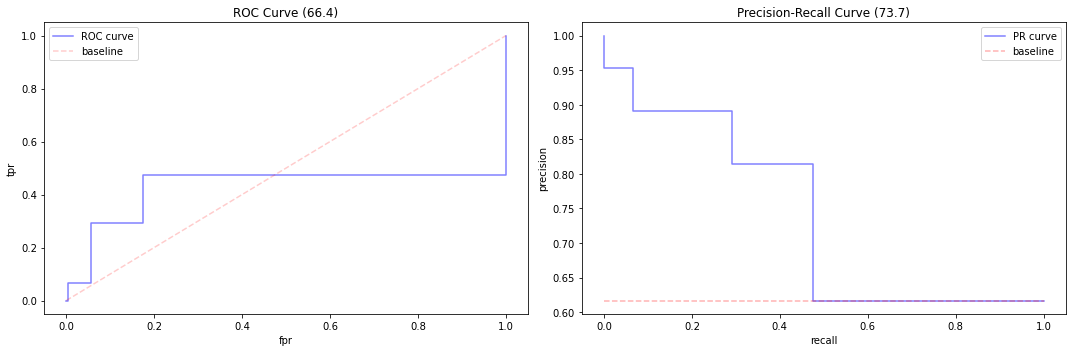

In [3]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

def plot_roc(ax, y, y_pred):
    fpr, tpr, _ = roc_curve(y, y_pred)
    score = roc_auc_score(y, y_pred) * 100.0

    ax.step(fpr, tpr, color='b', alpha=0.5, where='post', label='ROC curve')
    ax.plot((0, 1), (0, 1), 'r--', alpha=0.2, label='baseline')
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title(f'ROC Curve ({score:.1f})')
    ax.legend()
    
def plot_pr(ax, y, y_pred):
    pre, rec, _ = precision_recall_curve(y, y_pred)
    baseline = np.sum(y) / len(y)
    score = average_precision_score(y, y_pred) * 100.0
    
    ax.step(rec, pre, color='b', alpha=0.5, where='post', label='PR curve')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title(f'Precision-Recall Curve ({score:.1f})')
    ax.plot((0, 1), (baseline, baseline), 'r--', alpha=0.3, label='baseline')
    ax.legend()
    
def do_plots(y, y_pred):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_roc(ax[0], y, y_pred)
    plot_pr(ax[1], y, y_pred)

    plt.tight_layout()
    
do_plots(y, y_pred)

0.6638230525273362
0.7372705382262098


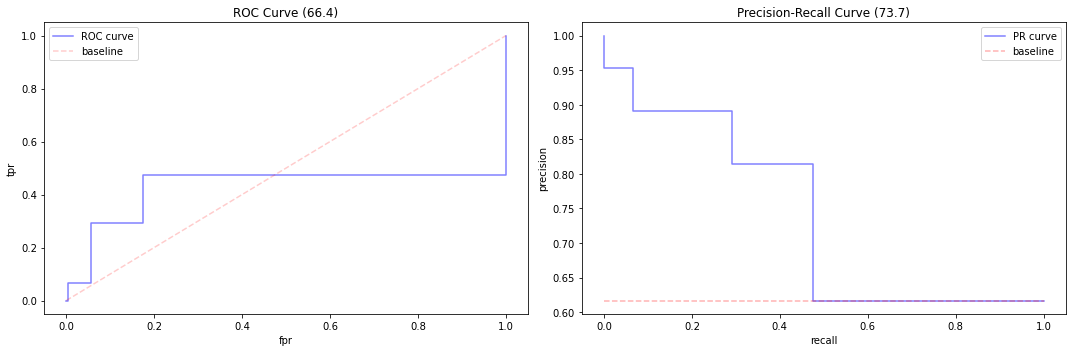

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=37)
rf.fit(X, y)

y_pred = rf.predict_proba(X)[:,1]
print(roc_auc_score(y, y_pred))
print(average_precision_score(y, y_pred))
do_plots(y, y_pred)

0.6638230525273362
0.7372705382262098


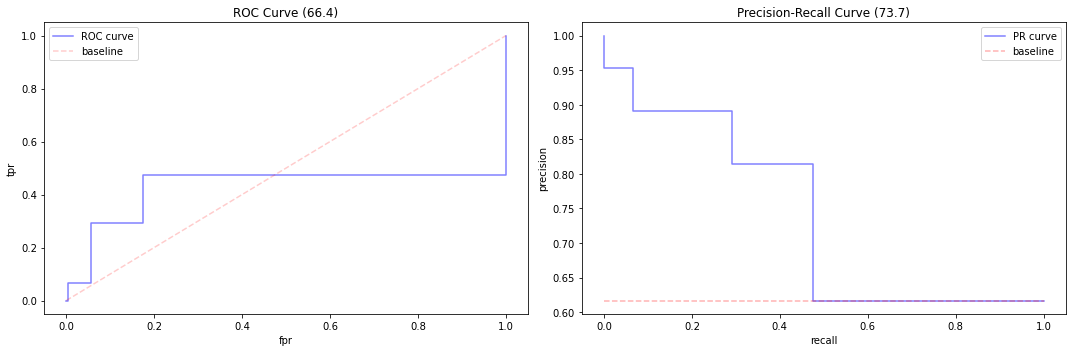

In [5]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X, y)

y_pred = nb.predict_proba(X)[:,1]

print(roc_auc_score(y, y_pred))
print(average_precision_score(y, y_pred))
do_plots(y, y_pred)

In [6]:
import pandas as pd

df = pd.DataFrame(np.hstack([X, y.reshape(N, 1)]), columns=['x1', 'x2', 'y'])

y_0 = df[df.y == 0].shape[0] / df.shape[0]
y_1 = df[df.y == 1].shape[0] / df.shape[0]

x1_00 = df[(df.y == 0) & (df.x1 == 0)].shape[0] / df.shape[0] / y_0
x1_01 = df[(df.y == 0) & (df.x1 == 1)].shape[0] / df.shape[0] / y_0
x1_10 = df[(df.y == 1) & (df.x1 == 0)].shape[0] / df.shape[0] / y_1
x1_11 = df[(df.y == 1) & (df.x1 == 1)].shape[0] / df.shape[0] / y_1

x2_00 = df[(df.y == 0) & (df.x2 == 0)].shape[0] / df.shape[0] / y_0
x2_01 = df[(df.y == 0) & (df.x2 == 1)].shape[0] / df.shape[0] / y_0
x2_10 = df[(df.y == 1) & (df.x2 == 0)].shape[0] / df.shape[0] / y_1
x2_11 = df[(df.y == 1) & (df.x2 == 1)].shape[0] / df.shape[0] / y_1

print(y_0, y_1)
print(x1_00, x1_01, x1_10, x1_11)
print(x2_00, x2_01, x2_10, x2_11)

0.3833 0.6167
0.9428645969214715 0.05713540307852857 0.7086103453867358 0.29138965461326416
0.12183668145056092 0.8781633185494392 0.24939192476082372 0.7506080752391762


In [7]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

y = BbnNode(Variable(0, 'y', ['off', 'on']), [y_0, y_1])
x1 = BbnNode(Variable(1, 'x1', ['off', 'on']), [x1_00, x1_01, x1_10, x1_11])
x2 = BbnNode(Variable(2, 'x2', ['off', 'on']), [x2_00, x2_01, x2_10, x2_11])

bbn = Bbn() \
    .add_node(y) \
    .add_node(x1) \
    .add_node(x2) \
    .add_edge(Edge(y, x1, EdgeType.DIRECTED)) \
    .add_edge(Edge(y, x2, EdgeType.DIRECTED))

join_tree = InferenceController.apply(bbn)

for node, posteriors in join_tree.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

y : off=0.38330, on=0.61670
x1 : off=0.79840, on=0.20160
x2 : off=0.20050, on=0.79950


0.6638230525273362
0.7372705382262098


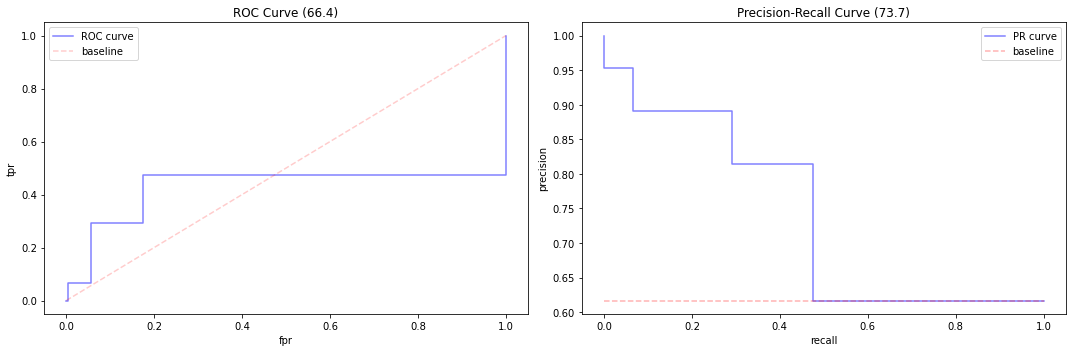

In [8]:
def predict_proba(r):
    x1_val = 'off' if r.x1 == 0 else 'on'
    x2_val = 'off' if r.x2 == 0 else 'on'
    
    ev1 = EvidenceBuilder() \
            .with_node(join_tree.get_bbn_node_by_name('x1')) \
            .with_evidence(x1_val, 1.0) \
            .build()
    ev2 = EvidenceBuilder() \
            .with_node(join_tree.get_bbn_node_by_name('x2')) \
            .with_evidence(x2_val, 1.0) \
            .build()
    ev = [ev1, ev2]
    
    join_tree.unobserve_all()
    join_tree.update_evidences(ev)
    posteriors = join_tree.get_posteriors()
    score = posteriors['y']['on']
    
    return score

y_pred = [predict_proba(r) for _, r in df.iterrows()]

print(roc_auc_score(df.y, y_pred))
print(average_precision_score(df.y, y_pred))
do_plots(df.y, y_pred)

In [9]:
x1_0 = df[df.x1 == 0].shape[0] / df.shape[0]
x1_1 = df[df.x1 == 1].shape[0] / df.shape[0]

x2_0 = df[df.x2 == 0].shape[0] / df.shape[0]
x2_1 = df[df.x2 == 1].shape[0] / df.shape[0]


y_000 = (df[(df.x1 == 0) & (df.x2 == 0) & (df.y == 0)].shape[0] / df.shape[0]) / (df[(df.x1 == 0) & (df.x2 == 0)].shape[0] / df.shape[0])
y_001 = (df[(df.x1 == 0) & (df.x2 == 0) & (df.y == 1)].shape[0] / df.shape[0]) / (df[(df.x1 == 0) & (df.x2 == 0)].shape[0] / df.shape[0])
y_010 = (df[(df.x1 == 0) & (df.x2 == 1) & (df.y == 0)].shape[0] / df.shape[0]) / (df[(df.x1 == 0) & (df.x2 == 1)].shape[0] / df.shape[0])
y_011 = (df[(df.x1 == 0) & (df.x2 == 1) & (df.y == 1)].shape[0] / df.shape[0]) / (df[(df.x1 == 0) & (df.x2 == 1)].shape[0] / df.shape[0])
y_100 = (df[(df.x1 == 1) & (df.x2 == 0) & (df.y == 0)].shape[0] / df.shape[0]) / (df[(df.x1 == 1) & (df.x2 == 0)].shape[0] / df.shape[0])
y_101 = (df[(df.x1 == 1) & (df.x2 == 0) & (df.y == 1)].shape[0] / df.shape[0]) / (df[(df.x1 == 1) & (df.x2 == 0)].shape[0] / df.shape[0])
y_110 = (df[(df.x1 == 1) & (df.x2 == 1) & (df.y == 0)].shape[0] / df.shape[0]) / (df[(df.x1 == 1) & (df.x2 == 1)].shape[0] / df.shape[0])
y_111 = (df[(df.x1 == 1) & (df.x2 == 1) & (df.y == 1)].shape[0] / df.shape[0]) / (df[(df.x1 == 1) & (df.x2 == 1)].shape[0] / df.shape[0])

print(x1_0, x1_1)
print(x2_0, x2_1)
print(y_000, y_001, y_010, y_011, y_100, y_101, y_110, y_111)

0.7984 0.2016
0.2005 0.7995
0.28219696969696967 0.7178030303030302 0.49484374999999997 0.50515625 0.04750593824228029 0.9524940617577197 0.12476489028213167 0.8752351097178683


In [10]:
y = BbnNode(Variable(0, 'y', ['off', 'on']), [y_000, y_001, y_010, y_011, y_100, y_101, y_110, y_111])
x1 = BbnNode(Variable(1, 'x1', ['off', 'on']), [x1_0, x1_1])
x2 = BbnNode(Variable(2, 'x2', ['off', 'on']), [x2_0, x2_1])

bbn = Bbn() \
    .add_node(y) \
    .add_node(x1) \
    .add_node(x2) \
    .add_edge(Edge(x1, y, EdgeType.DIRECTED)) \
    .add_edge(Edge(x2, y, EdgeType.DIRECTED))

join_tree = InferenceController.apply(bbn)

for node, posteriors in join_tree.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

x1 : off=0.79840, on=0.20160
x2 : off=0.20050, on=0.79950
y : off=0.38307, on=0.61693


0.6638230525273362
0.7372705382262098


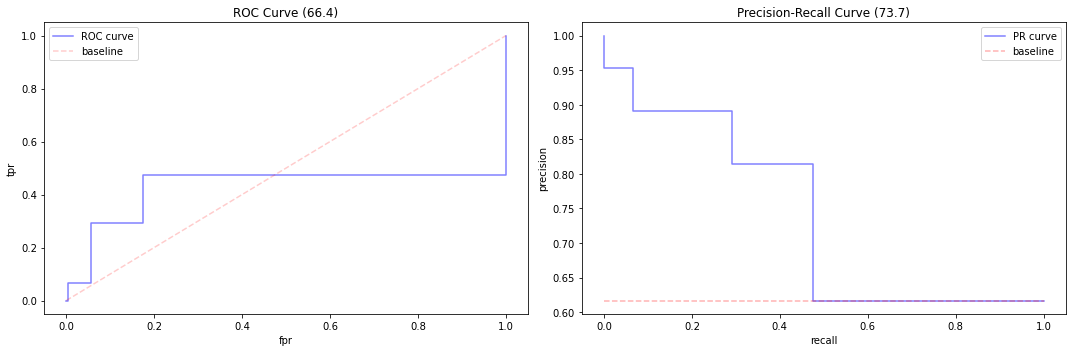

In [11]:
y_pred = [predict_proba(r) for _, r in df.iterrows()]

print(roc_auc_score(df.y, y_pred))
print(average_precision_score(df.y, y_pred))
do_plots(df.y, y_pred)